# Vehicle detection and tracking project

<img style="float: left; width: 500px;" src="output_images/title.png">

*picture by Udacity*

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

In [21]:
vehs = []
for image in os.listdir(os.getcwd() + "/vehicles/GTI_Right"):
    vehs.append(os.getcwd() + "/vehicles/GTI_Right/" + image)
    
for image in os.listdir(os.getcwd() + "/vehicles/GTI_MiddleClose"):
    vehs.append(os.getcwd() + "/vehicles/GTI_MiddleClose/" + image)

for image in os.listdir(os.getcwd() + "/vehicles/GTI_Left"):
    vehs.append(os.getcwd() + "/vehicles/GTI_Left/" + image)

for image in os.listdir(os.getcwd() + "/vehicles/GTI_Far"):
    vehs.append(os.getcwd() + "/vehicles/GTI_Far/" + image)

for image in os.listdir(os.getcwd() + "/vehicles/KITTI_extracted"):
    vehs.append(os.getcwd() + "/vehicles/KITTI_extracted/" + image)
    
non_vehs = []
for image in os.listdir(os.getcwd() + "/non-vehicles/GTI"):
    non_vehs.append(os.getcwd() + "/non-vehicles/GTI/" + image)
    
for image in os.listdir(os.getcwd() + "/non-vehicles/Extras"):
    non_vehs.append(os.getcwd() + "/non-vehicles/Extras/" + image)  

print(len(vehs))
print(len(non_vehs))
print(non_vehs[0])



8792
8968
C:\UDACITY\SelfDrivingCar_Nanodegree\Term1\CarND-Vehicle-Detection-master-P5/non-vehicles/GTI/image1.png


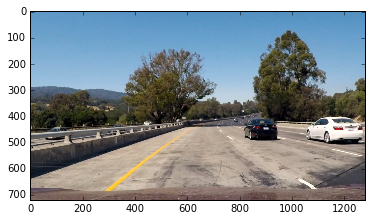

In [22]:
testimg1 = mpimg.imread("test_images/test1.jpg")
plt.imshow(testimg1)
plt.show()

## 1. Functions to extract the features

### 1.1 get color features

In [23]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [24]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

### 1.2 get hog features

In [25]:
from skimage.feature import hog

In [26]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [27]:
# example
exp_img = cv2.cvtColor(mpimg.imread(vehs[0]), cv2.COLOR_RGB2GRAY)

C:\Anaconda3\envs\tensorflow-with-gpu-10\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


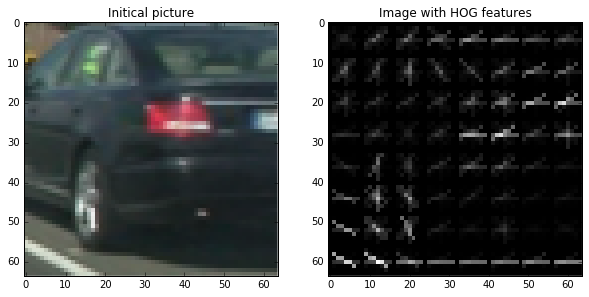

In [28]:
feats, hogImg = get_hog_features(exp_img, 8, 8, 2, vis=True, feature_vec=True)

fig1 = plt.figure(figsize = (10,10))
ax1 = fig1.add_subplot(121)
ax1.imshow(mpimg.imread(vehs[0]), interpolation='none')
ax1.set_title('Initical picture')
ax3 = fig1.add_subplot(122)
ax3.imshow(hogImg, interpolation='none', cmap="gray")
ax3.set_title('Image with HOG features')
plt.show()

### 1.3 combine and normalize

In [29]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # Apply color conversion
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the list of features
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 2. Search frames and find boxes

**The following functions were built to evaluate and test the performance on single images, later on the functions are implemented in a class object with enhanced performance**

### 2.1 sliding windows function

In [30]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window parameters to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### 2.2 draw boxes function

In [31]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Copy the image
    imcopy = np.copy(img)
    # Iterate through the boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### 2.3 single image features extraction

In [32]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Empty list
    img_features = []
    # Apply color conversion
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)

### Search windows function

In [33]:

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    # Create an empty list for the found windows
    on_windows = []
    # Iterate over all windows in the windows list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        #If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

In [34]:
# RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb' 
# HOG orientations
orient = 9
# Pix per cell
pix_per_cell = 8
# Cells per block
cell_per_block = 2
# Hog channel (1,2,3 or ALL)
hog_channel = "ALL" 
# Dimension for spatial binning
spatial_size = (32, 32) 
# Number of histogram bins
hist_bins = 32 
spatial_feat = True 
hist_feat = True 
hog_feat = True 
y_start_stop = [350, None]
hist_range = (0, 256)

## 3. Training the classifier

In [35]:
# Get the features of cars and noncars
car_features = extract_features(vehs, color_space, spatial_size, hist_bins, orient, pix_per_cell, 
                                cell_per_block, hog_channel)

noncar_features = extract_features(non_vehs, color_space, spatial_size, hist_bins, orient, pix_per_cell, 
                                cell_per_block, hog_channel)


C:\Anaconda3\envs\tensorflow-with-gpu-10\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [36]:
# Check length of extracted image paths

print(len(car_features))
print(len(noncar_features))
print(np.shape(car_features))
print(np.shape(noncar_features))

8792
8968
(8792, 8460)
(8968, 8460)


In [37]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
print(y.shape)

(17760,)


In [38]:
X = np.vstack((car_features, noncar_features)).astype(np.float64)
print(X.shape)

(17760, 8460)


#### Data normalization and classifier training

In [39]:
# Normalize training data
from sklearn.preprocessing import StandardScaler
X_Scaler = StandardScaler().fit(X)
X_scaled = X_Scaler.transform(X)

In [40]:
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
# Split data in train/test data and shuffle it
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = rand_state)

In [41]:
from sklearn.svm import LinearSVC
# Train support vector machine
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Get the accuarcy of the classifier

In [42]:
# Check the test accuarcy of the linear support vector machine
svc.score(X_test, y_test)

0.98761261261261257

## 4. Implementation of sliding windows search (exemplary)

C:\Anaconda3\envs\tensorflow-with-gpu-10\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


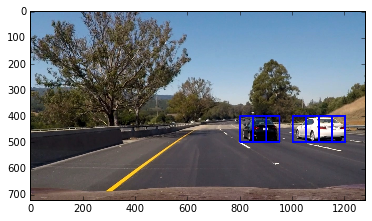

In [45]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Scale the image since its a .jpg
image = image.astype(np.float32)/255

# Search with three different window sizes
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(100, 100), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(200, 200), xy_overlap=(0.3, 0.3))
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.3, 0.3))

# Get the found windows that match the features as list
hot_windows = search_windows(image, windows, svc, X_Scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)                       
hot_windows2 = search_windows(image, windows2, svc, X_Scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
hot_windows3 = search_windows(image, windows3, svc, X_Scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Draw the found windows that match the features in boxes
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
window_img2 = draw_boxes(window_img, hot_windows2, color=(0, 0, 255), thick=6)
window_img3 = draw_boxes(window_img2, hot_windows2, color=(0, 0, 255), thick=6)
plt.imshow(window_img3)

In [46]:
# helper function for color conversion

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

### 4.1 find cars function

In [47]:
# find cars function as shown in the lession
# function uses a scale-factor to search with different window sizes
# function as well replaces the overlapping with cells_per_steps

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    boxes = []
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale),(np.int(imshape[0]/scale))))
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        #Blocks and steps
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
        nfeat_per_block = orient * cell_per_block**2
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        # Replacing overlapping with cells_per_step
        cells_per_step = 2
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        #get hog features
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract hog features
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                x_left = xpos * pix_per_cell
                y_top = ypos * pix_per_cell
                
                # Extract img patch
                subimg = cv2.resize(ctrans_tosearch[y_top:y_top+window, x_left:x_left+window],(64,64))
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                #test_features2 = np.concatenate((spatial_features, hist_features, hog_features))
                #test_features = X_scaler.transform(np.array(test_features2)).reshape(1, -1)
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, 
                                                             hog_features)).reshape(1, -1))
                test_prediction = svc.predict(test_features)
                
                if test_prediction == 1:
                    xbox_left = np.int(x_left * scale)
                    ytop_draw = np.int(y_top * scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+
                                                                         win_draw+ystart),(0,0,255),6)
                    boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+
                                                                         win_draw+ystart)))
        return draw_img, boxes

C:\Anaconda3\envs\tensorflow-with-gpu-10\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


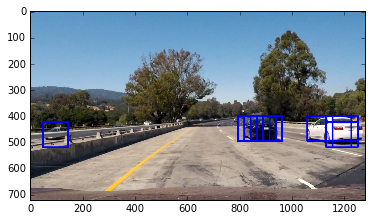

In [48]:
ystart = 400
ystop = 656
scale = 1.5
img_test = mpimg.imread('test_images/test1.jpg')

out_img, boxes = find_cars(img_test, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [49]:
print(boxes)

[((48, 424), (144, 520)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520))]


### 4.2 Add heatmap to cut out false-positives

In [50]:
# Heatmap functions / False positives
threshold = 1
heat = np.zeros_like(img_test[:,:,0]).astype(np.float)

In [51]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_boxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #print(bbox[0], bbox[1])
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        img = draw_boxes(img, [bbox], color=(0, 0, 255), thick=6)
    return img

2 vehicles found


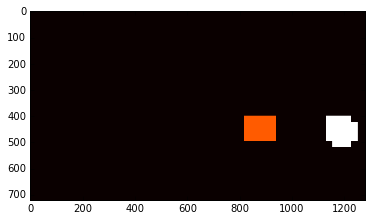

In [52]:
heat = add_heat(heat, boxes)
heat= apply_threshold(heat, threshold)
heatmap = np.clip(heat, 0, 255)
from scipy.ndimage.measurements import label
labels = label(heatmap)
print(labels[1], 'vehicles found')
plt.imshow(labels[0], cmap='hot')


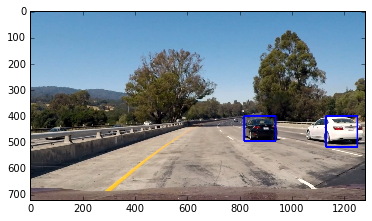

In [53]:
draw_img2 = draw_labeled_boxes(np.copy(img_test), labels)
plt.imshow(draw_img2)

In [32]:
# pulling everything together
threshold = 1

In [33]:
def vehicle_detection(image, ystart, ystop, scale, svc, X_Scaler, orient,pix_per_cell, cell_per_block, spatial_size,
                      hist_bins, threshold):
    #find cars in image
    out_img, boxes = find_cars(image, ystart, ystop, scale, svc, X_Scaler, orient, 
                               pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img_test[:,:,0]).astype(np.float)
    box_list = boxes
    heat = add_heat(heat, box_list)
    heat= apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_boxes(np.copy(image), labels)
    return draw_img
    


C:\Anaconda3\envs\tensorflow-with-gpu-10\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


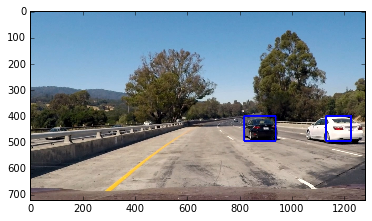

In [34]:
draw_img = vehicle_detection(np.copy(img_test), ystart, ystop, scale, svc, X_Scaler, orient,pix_per_cell, cell_per_block, spatial_size,
                      hist_bins, threshold) 
plt.imshow(draw_img)

In [35]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
def process_image(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed_img = vehicle_detection(image, ystart, ystop, scale, svc, X_Scaler, orient,pix_per_cell, cell_per_block, spatial_size,
                      hist_bins, threshold)
    return processed_img

In [38]:
#smooth the pipeline outcome

In [39]:
def find_cars_multiscale(img, ystart_ystop_scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    for (ystart, ystop, scale) in ystart_ystop_scale:
    
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        boxes = []
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale),(np.int(imshape[0]/scale))))
            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]
            # Blocks and steps
            nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
            nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
            nfeat_per_block = orient * cell_per_block**2
            window = 64
            nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
            cells_per_step = 2
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step
            # Extract hog features
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

            for xb in range(nxsteps):
                for yb in range(nysteps):
                    ypos = yb * cells_per_step
                    xpos = xb * cells_per_step
                    
                    # Extract hog features
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    x_left = xpos * pix_per_cell
                    y_top = ypos * pix_per_cell

                    #extract img patch
                    subimg = cv2.resize(ctrans_tosearch[y_top:y_top+window, x_left:x_left+window],(64,64))
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)

                    #test_features2 = np.concatenate((spatial_features, hist_features, hog_features))
                    #test_features = X_scaler.transform(np.array(test_features2)).reshape(1, -1)
                    test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, 
                                                                 hog_features)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)

                    if test_prediction == 1:
                        xbox_left = np.int(x_left * scale)
                        ytop_draw = np.int(y_top * scale)
                        win_draw = np.int(window*scale)
                        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+
                                                                             win_draw+ystart),(0,0,255),6)
                        boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+
                                                                             win_draw+ystart)))
        return draw_img, boxes

In [40]:
from collections import deque
heatmaps = deque(maxlen=3)
threshold = 2 
ystart_ystop_scale = [(400, 560, 1.5), (450, 650, 1.8), (500, 700, 2.5)]



In [41]:
def vehicle_detection_smooth(image, ystart_ystop_scale, svc, X_Scaler, orient,pix_per_cell, 
                             cell_per_block, spatial_size, hist_bins, threshold):
    # find cars in image
    out_img, boxes = find_cars_multiscale(image, ystart_ystop_scale, svc, X_Scaler, orient, 
                               pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img_test[:,:,0]).astype(np.float)
    box_list = boxes
    
    current_heatmap = add_heat(image, box_list)
    heatmaps.append(current_heatmap)
    heatmap_sum = sum(heatmaps)

    heat = apply_threshold(heatmap_sum, threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_boxes(np.copy(image), labels)
    return draw_img

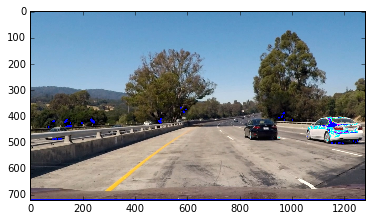

In [42]:
draw_img = vehicle_detection_smooth(np.copy(img_test), ystart_ystop_scale, svc, X_Scaler, orient,pix_per_cell, cell_per_block, spatial_size,
                      hist_bins, threshold) 
plt.imshow(draw_img)

## 5. VehicleDetector Class Object

**This class object combines the prework described above in one class object**

In [ ]:
# To make thing easier the following class object, comprising the relevant functions to detect vehicles, is created.

In [43]:
class VehicleDetector:
    def __init__(self):
        
        # Init the class using the parameters as for the single functions before
        self.color_space = 'YCrCb' 
        self.orient = 9 
        self.pix_per_cell = 8 
        self.cell_per_block = 2 
        self.hog_channel = "ALL" 
        self.spatial_size = (32, 32) 
        self.hist_bins = 32    
        self.spatial_feat = True 
        self.hist_feat = True 
        self.hog_feat = True 
        
        
        # Current heatmap
        self.heatmap = None

        # Heatmaps of last 3 frames
        self.heat_images = deque(maxlen=3)

        self.frame_count = 0
        self.full_frame_processing_interval = 10

        # Xstart
        self.xstart = 600

        # Various Scales
        self.ystart_ystop_scale = None

        # Kernal For Dilation
        self.kernel = np.ones((50, 50))

        # Threshold for Heatmap
        self.threshold = None
        
        self.X_scaler = X_Scaler
        self.svc = svc


    def find_cars_smooth(self, img):
        X_scaler = self.X_scaler
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        svc = self.svc

        box_list = []

        draw_img = np.copy(img)
        img = img.astype(np.float32) / 255

        if self.frame_count % self.full_frame_processing_interval == 0:
            mask = np.ones_like(img[:, :, 0])
        else:
            mask = np.sum(np.array(self.heat_images), axis=0)
            mask[(mask > 0)] = 1
            mask = cv2.dilate(mask, self.kernel, iterations=1)

        self.frame_count += 1

        for (ystart, ystop, scale) in self.ystart_ystop_scale:

            nonzero = mask.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            if len(nonzeroy) != 0:
                ystart = max(np.min(nonzeroy), ystart)
                ystop = min(np.max(nonzeroy), ystop)
            if len(nonzeroy) != 0:
                xstart = max(np.min(nonzerox), self.xstart)
                xstop = np.max(nonzerox)
            else:
                continue

            if xstop <= xstart or ystop <= ystart:
                continue

            img_tosearch = img[ystart:ystop, xstart:xstop, :]
            ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ys = np.int(imshape[1] / scale)
                xs = np.int(imshape[0] / scale)
                if (ys < 1 or xs < 1):
                    continue
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

            if ctrans_tosearch.shape[0] < 64 or ctrans_tosearch.shape[1] < 64:
                continue

            ch1 = ctrans_tosearch[:, :, 0]
            ch2 = ctrans_tosearch[:, :, 1]
            ch3 = ctrans_tosearch[:, :, 2]

            nxblocks = (ch1.shape[1] // pix_per_cell) - 1
            nyblocks = (ch1.shape[0] // pix_per_cell) - 1
            nfeat_per_block = orient * cell_per_block ** 2
            window = 64
            nblocks_per_window = (window // pix_per_cell) - 1
            cells_per_step = 2
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step

            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

            for xb in range(nxsteps + 1):
                for yb in range(nysteps + 1):
                    ypos = yb * cells_per_step
                    xpos = xb * cells_per_step

                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos * pix_per_cell
                    ytop = ypos * pix_per_cell

                    # Extract the image patch
                    subimg = ctrans_tosearch[ytop:ytop + window, xleft:xleft + window]

                    # Get color features
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)

                    # Scale features and make a prediction
                    test_features = X_scaler.transform(
                        np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                    # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)
                    if test_prediction == 1:
                        xbox_left = xstart + np.int(xleft * scale)
                        ytop_draw = np.int(ytop * scale)
                        win_draw = np.int(window * scale)
                        box_list.append(
                            ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

        # Add heat to each box in box list
        self.add_heatmap_and_threshold(draw_img, box_list, self.threshold)

        # Find final boxes from heatmap using label function
        labels = label(self.heatmap)
        VehicleDetector.draw_labeled_bboxes_smooth(draw_img, labels)

        return draw_img
    
    
    def add_heatmap_and_threshold(self, draw_img, bbox_list, threshold):
        heatmap = np.zeros_like(draw_img[:, :, 0]).astype(np.float)

        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        self.heat_images.append(heatmap)
        self.heatmap = np.sum(np.array(self.heat_images), axis=0)
        self.heatmap[self.heatmap <= threshold] = 0

    @staticmethod
    def draw_labeled_bboxes_smooth(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)

## 6. Combining it with my last project submission

In [44]:
import pickle

with open('objs.pkl', 'rb') as f:
    mtx, dist = pickle.load(f)

In [45]:
def undistort_img(img, mtx, dist):
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undist

def grayscale(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def SobelOp(img, kernelSize, thresh_min, thresh_max):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = kernelSize)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = kernelSize)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return scaled_sobel, sxbinary

def HLSconv(img, s_thresh_min, s_thresh_max):
    # convert to hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_chan = hls[:,:,2]
    s_binary = np.zeros_like(s_chan)
    s_binary[(s_chan > s_thresh_min) & (s_chan <= s_thresh_max)] = 1
    return s_binary

def StackFilters(sxbinary, s_binary):
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))*255
    comb_binary = np.zeros_like(sxbinary)
    comb_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return comb_binary

def IMGwarp(img):
    src = np.float32([[740, 460], [1050, 680], [280, 680], [580, 460]])
    dst = np.float32([[950, 0], [950, 720], [370, 720], [370, 0]])
    img_size = (img.shape[1], img.shape[0])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, img_warped

def maskImage(img_w):
    mask = np.zeros_like(img_w)   
    ignore_mask_color = 255 
    ignore_mask_color2 = 0
    vertices = np.array([[(200, 720),(300, 200), (1100, 200), (1250,720)]], dtype=np.int32) 
    vertices2 = np.array([[(600, 720),(675, 450), (725, 450), (800,720)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask, vertices2, ignore_mask_color2)
    img_masked = cv2.bitwise_and(img_w, mask)
    return img_masked

def FindLanes(img_warped):
    histogram = np.sum(img_warped[img_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img_warped, img_warped, img_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    offset_shadow = 100    
    detected_left = False
    detected_right = False
    if (leftx_base > 300) & (leftx_base < 500):
        detected_left = True
    if (rightx_base > 800) & (rightx_base < 1000):
        detected_right = True
    if detected_left == False:
        leftx_base = np.argmax(histogram[:midpoint-offset_shadow])
    if detected_right == False:
        rightx_base = np.argmax(histogram[midpoint+offset_shadow:])+midpoint
    return midpoint, leftx_base, rightx_base, detected_left, out_img

def distanceMid(img2, right_fitx, left_fitx):
    camera_position = img2.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(camera_position - lane_center)
    center_offset = center_offset_pixels*xm_per_pix
    return center_offset

def WindowSearch(img_warped, n_win, marg, minpix, leftx_base, rightx_base, out_img):
    nwindows = n_win #9
    window_height = np.int(img_warped.shape[0]/nwindows)
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = marg 
    minpix = minpix 
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = img_warped.shape[0] - (window + 1) * window_height
        win_y_high = img_warped.shape[0] - window * window_height
        win_x_left_low = leftx_current - margin
        win_x_left_high = leftx_current + margin
        win_x_right_low = rightx_current - margin
        win_x_right_high = rightx_current + margin
        cv2.rectangle(out_img, (win_x_left_low, win_y_low),(win_x_left_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_x_right_low, win_y_low),(win_x_right_high, win_y_high), (0, 255, 0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_left_low) &
                          (nonzerox < win_x_left_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_right_low) &
                          (nonzerox < win_x_right_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if (len(good_left_inds) > minpix) & (len(good_right_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # concatenate found lane indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # extract the pixel positions
    left_x = nonzerox[left_lane_inds]
    left_y = nonzeroy[left_lane_inds]
    right_x = nonzerox[right_lane_inds]
    right_y = nonzeroy[right_lane_inds]
    # fit second order polynomial
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    # Visualize sliding windows
    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1] * ploty + right_fit[2] 
    return left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, left_x, left_y, right_x, right_y
                       
def curvature(left_x, left_y, right_x, right_y, ploty):
    lane_length = 30
    lane_width = 3.7
    y_eval = np.max(ploty)
    ym_per_pix = lane_length/720
    xm_per_pix = lane_width/580

    left_fit_cr = np.polyfit(left_y * ym_per_pix, left_x * xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y * ym_per_pix, right_x * xm_per_pix, 2)

    left_curverad_cr = ((1 + (2 * left_fit_cr[0] * y_eval*ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad_cr = ((1 + (2 * right_fit_cr[0] * y_eval*ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    return left_curverad_cr, right_curverad_cr
                       
def lanePosition():
    left_pos = (midpoint - leftx_base) * xm_per_pix
    right_pos = (rightx_base - midpoint) * xm_per_pix
    line_base_pos = np.min([left_pos, right_pos])
    return left_pos, right_pos, line_base_pos

def warpBack(img_warped, left_fitx, right_fitx, ploty, Minv, image_undist):
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the points
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp back to original image
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_undist.shape[1], image_undist.shape[0]))
    result = cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
    return result

def select_yellow(image_in):
    image_in2 = cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image_in2, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)

    return mask

def select_white(image_in):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image_in, lower, upper)

    return mask

def comb_thresh(image_in):
    yellow = select_yellow(image_in)
    white = select_white(image_in)

    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1

    return combined_binary
    
def pipeline3(image, mtx, dist, kernelSize):
    out1 = undistort_img(image, mtx, dist)
    out2 = comb_thresh(out1)
    M, Minv, out3 = IMGwarp(out2)
    mid, leftxbase, rightxbase, detected, out_img = FindLanes(out3)
    left_inds, right_inds, leftfit, rightfit, plotyy, leftx, lefty, rightx, righty = WindowSearch(out3, 
                                                                                                  9, 100, 10, 
                                                                                                  leftxbase, rightxbase, 
                                                                                                  out_img)
    left_curverad_cr, right_curverad_cr = curvature(leftx, lefty, rightx, righty, plotyy) 
    left_fitx = leftfit
    right_fitx = rightfit
    
    
    global l_fit_buffer
    global r_fit_buffer
    global old_img_lines
    
    if old_img_lines is None:
        old_img_lines = out2
    
    # Compare new frame to previous frame
    ret = cv2.matchShapes(old_img_lines, out2, 1, 0.0)
    
    if ret < 50:
        old_img_lines = out2
        
        if l_fit_buffer is None:
            l_fit_buffer = np.array([left_fitx])

        if r_fit_buffer is None:
            r_fit_buffer = np.array([right_fitx])

    l_fit_buffer = np.append(l_fit_buffer, [left_fitx], axis=0)[-filter_size:]
    r_fit_buffer = np.append(r_fit_buffer, [right_fitx], axis=0)[-filter_size:]     
    
    # Compute the mean
    l_fit_mean = np.mean(l_fit_buffer, axis=0)
    r_fit_mean = np.mean(r_fit_buffer, axis=0)     
    
    result2 = warpBack(out3, leftfit, rightfit, plotyy, Minv, out1)
    return result2

In [46]:
vehicleDetector = VehicleDetector()
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 2

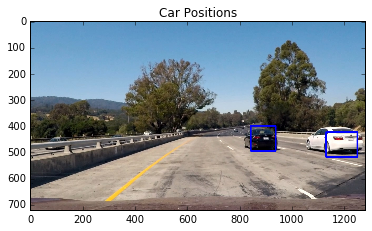

In [47]:
image3 = mpimg.imread('test_images/test1.jpg')
output3 = vehicleDetector.find_cars_smooth(image3)
plt.figure()
plt.imshow(output3)
plt.title('Car Positions')

In [48]:
filter_size = 10
old_img_lines = None
l_fit_buffer = None
r_fit_buffer = None
def process_image_lanes(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed_img = pipeline3(image, mtx, dist, 5)
    return processed_img


In [57]:
#combine both
vehicleDetector = VehicleDetector()
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 2

filter_size = 10
old_img_lines = None
l_fit_buffer = None
r_fit_buffer = None

def process_image_comb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed_img = pipeline3(image, mtx, dist, 5)
    processed_img = cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR)
    processed_img2 = vehicleDetector.find_cars_smooth(processed_img)
    return processed_img2

In [58]:
project_video_output = './output_videos/project_video_output_comb.mp4'
clip9000 = VideoFileClip("./project_video.mp4")
white_clip9000 = clip9000.fl_image(process_image_comb)
%time white_clip9000.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_output_comb.mp4
[MoviePy] Writing video ./output_videos/project_video_output_comb.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:49<00:00,  3.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output_comb.mp4 

Wall time: 5min 50s
